In [29]:
import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt

%matplotlib inline

In [30]:
np.random.seed(5)


In [31]:
data_path = "../data/raw_data/"

raw_data = pd.read_csv(f"{data_path}heart_cleveland_upload.csv")
raw_data


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


Посмотрим на кол-во пропусков

In [32]:
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


поделим признаки на численные и категориальные

In [33]:
cat_feats = []

for feat in raw_data.columns:
    if raw_data[feat].nunique() < raw_data.shape[0] / 10:
        cat_feats.append(feat)


num_feats = list(set(raw_data.columns).difference(cat_feats))


In [34]:
raw_data[cat_feats].astype("str").describe()


,sex,cp,fbs,restecg,exang,slope,ca,thal,condition
count,297,297,297,297,297,297,297,297,297
unique,2,4,2,3,2,3,4,3,2
top,1,3,0,0,0,0,0,0,0
freq,201,142,254,147,200,139,174,164,160


In [35]:
raw_data[num_feats].describe()


,age,thalach,oldpeak,chol,trestbps
count,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,149.599327,1.055556,247.350168,131.693603
std,9.049736,22.941562,1.166123,51.997583,17.762806
min,29.000000,71.000000,0.000000,126.000000,94.000000
25%,48.000000,133.000000,0.000000,211.000000,120.000000
50%,56.000000,153.000000,0.800000,243.000000,130.000000
75%,61.000000,166.000000,1.600000,276.000000,140.000000
max,77.000000,202.000000,6.200000,564.000000,200.000000


Посмотрим на категориальные признаки и таргет и их распределения

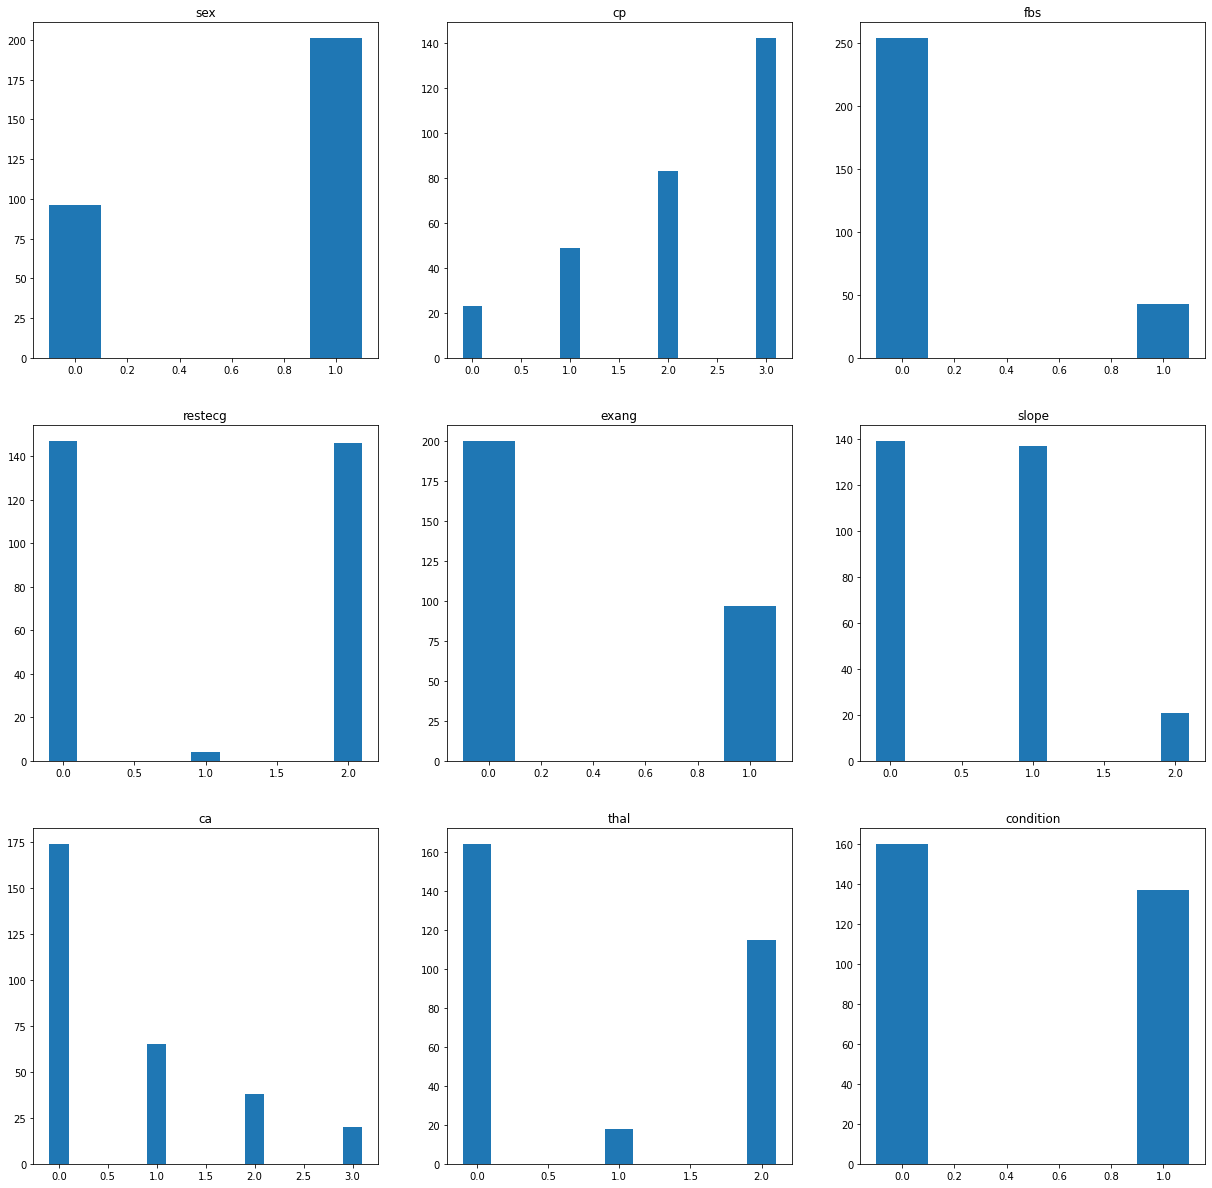

In [36]:
fig, axs = plt.subplots(3, 3, figsize=(21, 21))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i, j].set_title(cat_feats[i * 3 + j])
        d = raw_data[cat_feats[i * 3 + j]].value_counts().to_dict()
        axs[i, j].bar(d.keys(), d.values(), width=0.2, bottom=0)

plt.show()


Посмотрим на распределения численных признаков

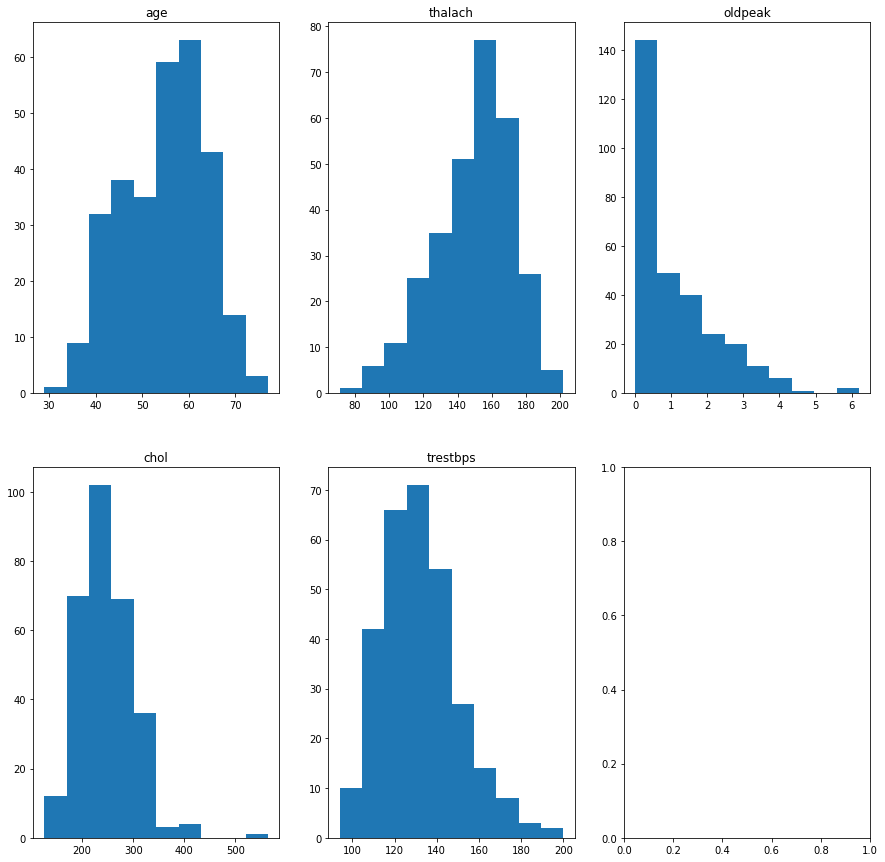

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15))
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        if i + j < 3:
            axs[i, j].set_title(num_feats[i * 3 + j])
            d = raw_data[num_feats[i * 3 + j]]
            axs[i, j].hist(d)

plt.show()


In [38]:
X = raw_data[raw_data.columns.to_list()[:-1]]
y = raw_data["condition"]
feats = raw_data.columns.to_list()[:-1]
del raw_data


In [39]:
feats_mi = zip(
    feats,
    mutual_info_classif(X, y),
)
for feat, mi in feats_mi:
    print(f"{feat}: {round(mi, 4)}")


age: 0.0
sex: 0.0287
cp: 0.1511
trestbps: 0.0
chol: 0.0857
fbs: 0.0028
restecg: 0.0323
thalach: 0.0834
exang: 0.0649
oldpeak: 0.0746
slope: 0.0632
ca: 0.0929
thal: 0.1358


Данных мало => сразу попробую посмотреть скор линейной регрессии/рандомфореста без препроцессинга данных

линейка - простая модель, а рандом форест - хороший бейзлайн(и не переобучается особо)

In [40]:
skf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
)
skf_split = skf.split(X, y)


In [41]:
log_reg_model = LogisticRegression(
    n_jobs=-1,
)
cross_val_score(
    estimator=log_reg_model,
    X=X,
    y=y,
    cv=skf,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
)


/home/bovrrr/Source/repos/made/second_semester/ml_in_production/Bovrrr/hw_1_ml_in_prod_made/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/bovrrr/Source/repos/made/second_semester/ml_in_production/Bovrrr/hw_1_ml_in_prod_made/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

array([0.81395349, 0.84090909, 0.84444444])

In [42]:
rf_model = RandomForestClassifier(
    n_jobs=-1,
)
cross_val_score(
    estimator=rf_model,
    X=X,
    y=y,
    cv=skf,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
)


array([0.84782609, 0.79120879, 0.8       ])

Значит наша финальная модель должна быть не хуже этого скора.